# Data

## Imports y Parametros

In [ ]:
# Imports
import os, time, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

# Sk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern


# Parámetros
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

FEATURES_DIR = Path("features_aug")
FEATURES_DIR.mkdir(exist_ok=True)
FEAT_INDEX_PATH = FEATURES_DIR / "features_index.csv"
MODEL_DIR = Path("models_ae")
MODEL_DIR.mkdir(exist_ok=True)
LATENT_DIM = 64
AE_EPOCHS = 60
BATCH_AE = 128
LR = 1e-3
ALPHA = 0.05
AUG_TARGET_PER_CLASS = 6000
IMG_SIZE = (299,299)
CSV_IN = "metadata.csv"
IMAGES_ROOT = Path("COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset")
AUG_ROOT = Path("COVID-19_Radiography_Dataset_augmented")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Funciones Auxiliares

In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_root=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_root = Path(img_root) if img_root is not None else None
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        if 'filepath' in row and isinstance(row['filepath'], str) and row['filepath']:
            img_path = Path(row['filepath'])
        else:
            fname = row.get('file_name', row.get('filename', ''))
            if self.img_root is None:
                img_path = Path(fname)
            else:
                img_path = self.img_root / row['label'] / fname
        img = Image.open(img_path).convert('L')  # grayscale
        img = img.resize(IMG_SIZE)
        arr = np.array(img, dtype=np.uint8)  # uint8 para LBP
        # LBP
        lbp = local_binary_pattern(arr, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0,59))
        lbp_hist = lbp_hist.astype(np.float32)
        lbp_hist /= (lbp_hist.sum() + 1e-9)
        # intensity hist
        hist, _ = np.histogram(arr.ravel(), bins=32, range=(0,256))
        hist = hist.astype(np.float32)
        hist /= (hist.sum() + 1e-9)
        features = np.concatenate([lbp_hist, hist]).astype(np.float32)
        features = torch.from_numpy(features)
        label = row['label']
        return features, label


In [4]:
class FeatureNpyWithLabelDataset(Dataset):
    def __init__(self, features_index_csv):
        self.df = pd.read_csv(features_index_csv).reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        feat = np.load(row['feat_path']).astype(np.float32)
        label = row['label']
        return torch.from_numpy(feat), label

In [16]:
class AE_MLP(nn.Module):
    def __init__(self, input_dim, latent_dim=LATENT_DIM, dropout=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

In [10]:
def class_distribution_report(df, label_col='label'):
    counts = df[label_col].value_counts(dropna=False).rename_axis('label').reset_index(name='count')
    total = counts['count'].sum()
    counts['pct'] = (counts['count'] / total * 100).round(2)
    display(counts)
    plt.figure(figsize=(8,5))
    sns.barplot(data=counts, x='label', y='count')
    plt.xticks(rotation=45)
    plt.title("Distribución de clases")
    plt.tight_layout()
    return

In [11]:
def random_augment_image_pil(img):
    """
    Solo aplica:
      - horizontal flip (prob 0.5)
      - ajuste de brillo (0.85 - 1.15)
      - ajuste de contraste (0.85 - 1.15)
    """
    # img: PIL Image
    if random.random() < 0.5:
        img = ImageOps.mirror(img)  # horizontal flip (left-right)
    # brightness
    enh_b = ImageEnhance.Brightness(img)
    img = enh_b.enhance(random.uniform(0.85, 1.15))
    # contrast
    enh_c = ImageEnhance.Contrast(img)
    img = enh_c.enhance(random.uniform(0.85, 1.15))
    return img


In [12]:
def ensure_augmented_dataset(csv_in=CSV_IN, images_root=IMAGES_ROOT, out_root=AUG_ROOT, target_per_class=AUG_TARGET_PER_CLASS):
    out_root = Path(out_root)
    if out_root.exists():
        print(f"{out_root} ya existe")
    out_root.mkdir(parents=True, exist_ok=True)

    meta = pd.read_csv(csv_in)
    # admitir columnas 'file_name' o 'filename'
    if 'file_name' not in meta.columns and 'filename' in meta.columns:
        meta = meta.rename(columns={'filename':'file_name'})
    meta['label'] = meta['label'].astype(str).str.strip()

    classes = sorted(meta['label'].unique())
    print("Clases detectadas:", classes)

    rows = []
    for cls in tqdm(classes, desc="Procesando clases"):
        # localizar archivos originales para esta clase
        fns = meta[meta['label']==cls]['file_name'].astype(str).tolist()
        found = []
        for fn in fns:
            candidate = images_root / cls / fn
            if candidate.exists():
                found.append(candidate)
            else:
                # búsqueda recursiva por basename
                matches = list(images_root.rglob(fn))
                if matches:
                    found.append(matches[0])
        if len(found) == 0:
            print(f"Warning: no encontré archivos para clase {cls}.")
            continue

        # crear carpeta de salida
        class_out = out_root / cls
        class_out.mkdir(parents=True, exist_ok=True)

        # copiar originales
        for src in found:
            if len(rows) in (6000, 12000, 18000):
                continue
            dst = class_out / src.name
            if not dst.exists():
                shutil.copy2(src, dst)
            rows.append({'file_name': src.name, 'label': cls, 'filepath': str(dst.resolve())})
                

        # contar y crear augmentaciones hasta objetivo
        current = len(list(class_out.iterdir()))
        i_aug = 0
        while current < target_per_class:
            src = random.choice(found)
            im = Image.open(src).convert('L').resize(IMG_SIZE)
            aug = random_augment_image_pil(im)
            base = Path(src).stem
            newname = f"{base}_aug_{i_aug}.png"
            outpath = class_out / newname
            # evitar sobreescribir
            if not outpath.exists():
                aug.save(outpath)
                rows.append({'file_name': newname, 'label': cls, 'filepath': str(outpath.resolve())})
                current += 1
            i_aug += 1

    df_aug = pd.DataFrame(rows)
    csv_out = out_root / "metadata_augmented.csv"
    df_aug.to_csv(csv_out, index=False)
    print("Augmented dataset creado en:", out_root)
    print("CSV guardado en:", csv_out)
    return df_aug

In [13]:
import glob

EXTENSION_IMAGEN = ".png"

def search_image(root_folder):
    valid_files = []
    # Obtener todas las subcarpetas de la carpeta raíz
    subfolders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for subfolder in subfolders:
        subfolder_path = os.path.join(root_folder, subfolder)
        # Buscar archivos .png en la subcarpeta
        png_files = glob.glob(os.path.join(subfolder_path, f'*{EXTENSION_IMAGEN}'))
        for file in png_files:
            valid_files.append((subfolder, file))

    return valid_files

def show_image_original_and_aug():
    base_candidates_1 = search_image(IMAGES_ROOT)

    found = False
    attempts = 0
    MAX_ATTEMPTS = 100

    while not found and attempts < MAX_ATTEMPTS:
        attempts += 1

        chosen_subfolder, original_image_path = random.choice(base_candidates_1)

        base_name = os.path.splitext(os.path.basename(original_image_path))[0]

        search_pattern = os.path.join(
            AUG_ROOT,
            chosen_subfolder,
            f'{base_name}_aug_*{EXTENSION_IMAGEN}'
        )

        found_aug_files = glob.glob(search_pattern)

        if found_aug_files:
            # Si encuentra una o más imágenes, elige una al azar y dibuja
            augmented_image_path = random.choice(found_aug_files)
            found = True

            try:
                original_img_pil = Image.open(original_image_path).convert('L')
                original_img = np.array(original_img_pil)

                augmented_img_pil = Image.open(augmented_image_path).convert('L')
                augmented_img = np.array(augmented_img_pil)

            except Exception as e:
                found = False

            if found:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))

                # Imagen Original
                axs[0].imshow(original_img, cmap='gray')
                axs[0].set_title(f"Original: {os.path.basename(original_image_path)}")
                axs[0].axis('off') # Ocultar ejes

                # Imagen Aumentada
                axs[1].imshow(augmented_img, cmap='gray')
                axs[1].set_title(f"Aumentada: {os.path.basename(augmented_image_path)}")
                axs[1].axis('off') # Ocultar ejes

                plt.suptitle(f"Par encontrado: Carpeta {chosen_subfolder}")
                plt.show()


    if attempts >= MAX_ATTEMPTS:
        print(f"Máximo de {MAX_ATTEMPTS} intentos alcanzado sin encontrar un par coincidente.")

In [14]:
def extract_features_df(df_aug, features_dir=FEATURES_DIR):
    rows = []
    ds = ChestXrayDataset(df_aug, img_root=None)
    for i in tqdm(range(len(ds)), desc="Extrayendo features (aug)"):
        feat, label = ds[i]
        feat_np = feat.numpy().astype(np.float32)
        fp = df_aug.iloc[i]['filepath'] if 'filepath' in df_aug.columns else None
        stem = Path(fp).stem if fp else f"sample_{i}"
        outp = features_dir / f"{stem}_feat.npy"
        np.save(outp, feat_np)
        rows.append({'feat_path': str(outp), 'label': label, 'filepath': str(df_aug.iloc[i]['filepath'])})
    df_feats = pd.DataFrame(rows)
    df_feats.to_csv(features_dir / "features_index.csv", index=False)
    print("Features guardadas en:", features_dir)
    return df_feats

## Preprocesamiento

,label,count,pct
0,Normal,10192,48.15
1,Lung_Opacity,6012,28.41
2,COVID,3616,17.08
3,Viral Pneumonia,1345,6.35


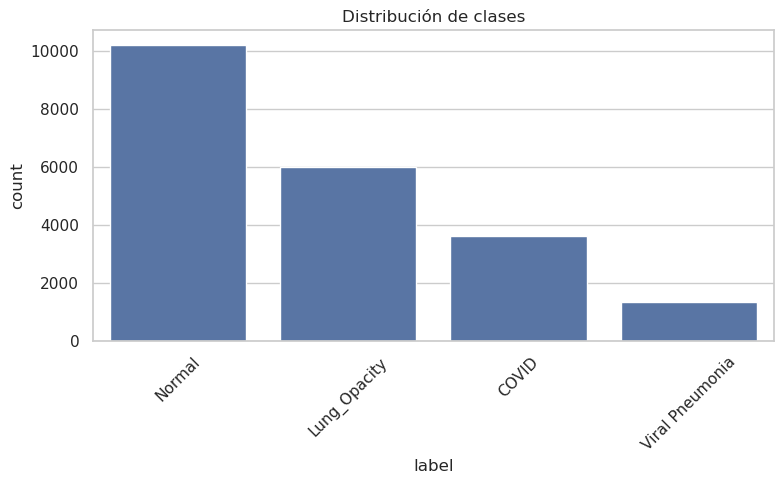

In [73]:
meta = pd.read_csv(CSV_IN)
class_distribution_report(meta, label_col='label')

Ya que hay sesgo, se opta por generar nuevos datos

Clases detectadas: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


Procesando clases: 100%|██████████| 4/4 [15:21<00:00, 230.33s/it]

Augmented dataset creado en: COVID-19_Radiography_Dataset_augmented
CSV guardado en: COVID-19_Radiography_Dataset_augmented/metadata_augmented.csv


,label,count,pct
0,COVID,6000,25.0
1,Lung_Opacity,6000,25.0
2,Normal,6000,25.0
3,Viral Pneumonia,6000,25.0


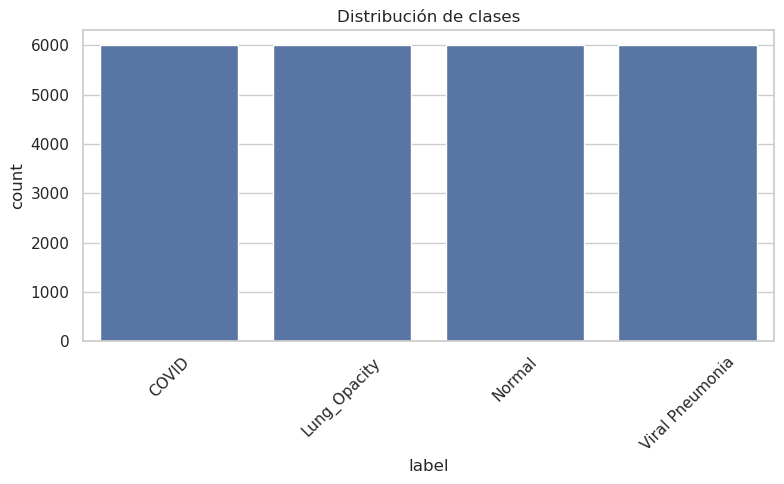

In [74]:
df_aug = ensure_augmented_dataset()
len(df_aug)
class_distribution_report(df_aug, label_col='label')

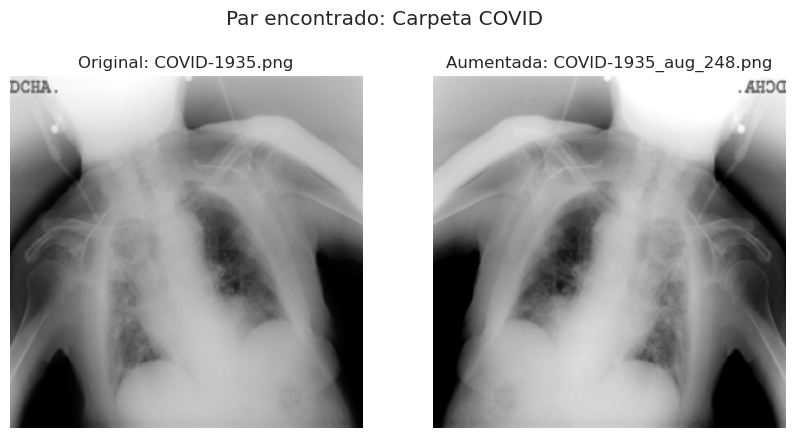

In [79]:
show_image_original_and_aug()

## Feature Engineering

Para el feature extractor se usa dos etapas:
* Manual:
    * LBP (Local Binary Patterns): Captura textura local de la imagen.
    * Histograma: Representa la distribución de intensidad de píxeles en la imagen.
* Automático:
    * Autoencoders: Representa mejorar los features de la etapa anterior.

In [80]:
df_feats = extract_features_df(df_aug)
df_feats.head()

Extrayendo features (aug): 100%|██████████| 24000/24000 [08:55<00:00, 44.84it/s] 


Features guardadas en: features_aug


,feat_path,label,filepath
0,features_aug/COVID-1_feat.npy,COVID,/home/hack/Desktop/TEC/2025 - Semestre 2/Patro...
1,features_aug/COVID-10_feat.npy,COVID,/home/hack/Desktop/TEC/2025 - Semestre 2/Patro...
2,features_aug/COVID-100_feat.npy,COVID,/home/hack/Desktop/TEC/2025 - Semestre 2/Patro...
3,features_aug/COVID-1000_feat.npy,COVID,/home/hack/Desktop/TEC/2025 - Semestre 2/Patro...
4,features_aug/COVID-1001_feat.npy,COVID,/home/hack/Desktop/TEC/2025 - Semestre 2/Patro...


In [20]:
feat_index = pd.read_csv(FEAT_INDEX_PATH)
print("Features index rows:", len(feat_index))
ds_all = FeatureNpyWithLabelDataset(FEAT_INDEX_PATH)

le = LabelEncoder()
feat_index['label_enc'] = le.fit_transform(feat_index['label'])
feat_index.to_csv(FEAT_INDEX_PATH, index=False)  # actualizar con encoding

idxs = np.arange(len(feat_index))
y = feat_index['label_enc'].values
train_idx, val_idx = train_test_split(idxs, test_size=0.1, stratify=y, random_state=SEED)
train_ds = Subset(FeatureNpyWithLabelDataset(FEAT_INDEX_PATH), train_idx)
val_ds   = Subset(FeatureNpyWithLabelDataset(FEAT_INDEX_PATH), val_idx)

# DataLoaders (devuelven (x, label_str) — convertiremos label a entero en batch)
train_loader = DataLoader(train_ds, batch_size=BATCH_AE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_AE, shuffle=False, num_workers=2, pin_memory=True)

# Check input dim
sample_feat = np.load(feat_index.loc[0,'feat_path']).astype(np.float32)
INPUT_DIM = sample_feat.shape[0]
print("INPUT_DIM:", INPUT_DIM, "train/val sizes:", len(train_ds), len(val_ds))


model = AE_MLP(INPUT_DIM, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=6, verbose=True)

best_val = float('inf')
best_epoch = -1
patience = 0

history = {'epoch':[], 'train_mse':[], 'val_mse':[], 'silhouette':[]}

for epoch in range(1, AE_EPOCHS+1):
    model.train()
    running_loss = 0.0
    n_train = 0
    for xb_batch, label_batch in tqdm(train_loader, desc=f"AE Train E{epoch}"):
        xb = xb_batch.to(DEVICE)
        optimizer.zero_grad()
        recon, z = model(xb)
        loss = F.mse_loss(recon, xb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        n_train += xb.size(0)
    train_mse = running_loss / max(1, n_train)

    # validation: compute val MSE and collect latents for silhouette (sample)
    model.eval()
    val_running = 0.0; n_val = 0
    latents_val = []
    labels_val = []
    with torch.no_grad():
        for xb_batch, label_batch in val_loader:
            xb = xb_batch.to(DEVICE)
            recon, z = model(xb)
            val_running += F.mse_loss(recon, xb, reduction='sum').item()
            n_val += xb.size(0)
            latents_val.append(z.cpu().numpy())
            labels_val.extend(label_batch)
    val_mse = val_running / max(1, n_val)
    if len(latents_val) > 0:
        Z_val = np.vstack(latents_val)
        # silhouette on subset to save tiempo
        n_sub = min(2000, Z_val.shape[0])
        if n_sub < Z_val.shape[0]:
            idxs_sub = np.random.choice(Z_val.shape[0], size=n_sub, replace=False)
            Zs = Z_val[idxs_sub]
            labs_s = np.array(labels_val)[idxs_sub]
        else:
            Zs = Z_val; labs_s = np.array(labels_val)
        try:
            sil = silhouette_score(Zs, LabelEncoder().fit_transform(labs_s))
        except Exception as e:
            sil = float('nan')
    else:
        sil = float('nan')

    scheduler.step(val_mse)

    history['epoch'].append(epoch)
    history['train_mse'].append(train_mse)
    history['val_mse'].append(val_mse)
    history['silhouette'].append(sil)

    print(f"E{epoch:03d} train_mse={train_mse:.6e} val_mse={val_mse:.6e} silhouette(sub)={sil:.4f} lr={optimizer.param_groups[0]['lr']:.1e}")

    # Early stopping on val_mse
    if val_mse < best_val - 1e-9:
        best_val = val_mse
        best_epoch = epoch
        patience = 0
        torch.save(model.state_dict(), MODEL_DIR/"best_ae_v2.pth")
        print("  Saved best AE_v2")
    else:
        patience += 1
        if patience >= 12:
            print(f"Early stopping at epoch {epoch} (no mejora en {12} epochs).")
            break

# guardar la historia
pd.DataFrame(history).to_csv(MODEL_DIR/"history_ae_v2.csv", index=False)
torch.save(model.state_dict(), MODEL_DIR/"last_ae_v2.pth")
print("Finished training. Best val MSE:", best_val, "at epoch", best_epoch)


Features index rows: 24000


/home/hack/miniconda3/envs/rpp2/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


INPUT_DIM: 91 train/val sizes: 21600 2400


AE_v2 Train E1: 100%|██████████| 169/169 [00:40<00:00,  4.16it/s]


E001 train_mse=1.421615e-02 val_mse=4.372062e-02 silhouette(sub)=-0.0593 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E2: 100%|██████████| 169/169 [00:41<00:00,  4.07it/s]


E002 train_mse=3.413624e-04 val_mse=2.264612e-02 silhouette(sub)=-0.0572 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E3: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]


E003 train_mse=2.175078e-04 val_mse=1.643869e-02 silhouette(sub)=-0.0599 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E4: 100%|██████████| 169/169 [00:36<00:00,  4.69it/s]


E004 train_mse=1.669982e-04 val_mse=1.272189e-02 silhouette(sub)=-0.0550 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E5: 100%|██████████| 169/169 [00:35<00:00,  4.75it/s]


E005 train_mse=1.402366e-04 val_mse=1.184328e-02 silhouette(sub)=-0.0572 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E6: 100%|██████████| 169/169 [00:41<00:00,  4.10it/s]


E006 train_mse=1.234106e-04 val_mse=1.118709e-02 silhouette(sub)=-0.0549 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E7: 100%|██████████| 169/169 [00:35<00:00,  4.74it/s]


E007 train_mse=1.135882e-04 val_mse=9.902862e-03 silhouette(sub)=-0.0522 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E8: 100%|██████████| 169/169 [00:40<00:00,  4.21it/s]


E008 train_mse=1.107316e-04 val_mse=8.270989e-03 silhouette(sub)=-0.0534 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E9: 100%|██████████| 169/169 [00:36<00:00,  4.60it/s]


E009 train_mse=1.089454e-04 val_mse=9.578513e-03 silhouette(sub)=-0.0501 lr=1.0e-03


AE_v2 Train E10: 100%|██████████| 169/169 [00:34<00:00,  4.96it/s]


E010 train_mse=1.068710e-04 val_mse=8.863181e-03 silhouette(sub)=-0.0480 lr=1.0e-03


AE_v2 Train E11: 100%|██████████| 169/169 [00:37<00:00,  4.45it/s]


E011 train_mse=1.102796e-04 val_mse=9.722914e-03 silhouette(sub)=-0.0333 lr=1.0e-03


AE_v2 Train E12: 100%|██████████| 169/169 [00:36<00:00,  4.63it/s]


E012 train_mse=1.109664e-04 val_mse=1.023799e-02 silhouette(sub)=-0.0424 lr=1.0e-03


AE_v2 Train E13: 100%|██████████| 169/169 [00:36<00:00,  4.66it/s]


E013 train_mse=1.066023e-04 val_mse=1.165722e-02 silhouette(sub)=-0.0318 lr=1.0e-03


AE_v2 Train E14: 100%|██████████| 169/169 [00:32<00:00,  5.14it/s]


E014 train_mse=1.023339e-04 val_mse=9.575347e-03 silhouette(sub)=-0.0317 lr=1.0e-03


AE_v2 Train E15: 100%|██████████| 169/169 [00:36<00:00,  4.57it/s]


E015 train_mse=1.001121e-04 val_mse=7.961370e-03 silhouette(sub)=-0.0298 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E16: 100%|██████████| 169/169 [00:33<00:00,  5.08it/s]


E016 train_mse=9.661366e-05 val_mse=7.821006e-03 silhouette(sub)=-0.0231 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E17: 100%|██████████| 169/169 [00:38<00:00,  4.42it/s]


E017 train_mse=9.210025e-05 val_mse=7.692888e-03 silhouette(sub)=-0.0171 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E18: 100%|██████████| 169/169 [00:35<00:00,  4.75it/s]


E018 train_mse=8.821391e-05 val_mse=7.810675e-03 silhouette(sub)=-0.0168 lr=1.0e-03


AE_v2 Train E19: 100%|██████████| 169/169 [00:36<00:00,  4.69it/s]


E019 train_mse=8.503942e-05 val_mse=8.359055e-03 silhouette(sub)=-0.0117 lr=1.0e-03


AE_v2 Train E20: 100%|██████████| 169/169 [00:42<00:00,  4.01it/s]


E020 train_mse=8.276549e-05 val_mse=7.176466e-03 silhouette(sub)=-0.0114 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E21: 100%|██████████| 169/169 [00:49<00:00,  3.43it/s]


E021 train_mse=8.074061e-05 val_mse=7.329311e-03 silhouette(sub)=-0.0136 lr=1.0e-03


AE_v2 Train E22: 100%|██████████| 169/169 [00:39<00:00,  4.23it/s]


E022 train_mse=7.901546e-05 val_mse=6.780253e-03 silhouette(sub)=-0.0103 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E23: 100%|██████████| 169/169 [00:41<00:00,  4.12it/s]


E023 train_mse=7.864185e-05 val_mse=6.768577e-03 silhouette(sub)=-0.0105 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E24: 100%|██████████| 169/169 [00:41<00:00,  4.06it/s]


E024 train_mse=7.888897e-05 val_mse=6.793505e-03 silhouette(sub)=-0.0074 lr=1.0e-03


AE_v2 Train E25: 100%|██████████| 169/169 [00:36<00:00,  4.67it/s]


E025 train_mse=7.931299e-05 val_mse=7.027692e-03 silhouette(sub)=-0.0098 lr=1.0e-03


AE_v2 Train E26: 100%|██████████| 169/169 [00:39<00:00,  4.29it/s]


E026 train_mse=8.147267e-05 val_mse=6.746885e-03 silhouette(sub)=-0.0075 lr=1.0e-03
  Saved best AE_v2


AE_v2 Train E27: 100%|██████████| 169/169 [00:33<00:00,  5.00it/s]


E027 train_mse=8.308948e-05 val_mse=7.702213e-03 silhouette(sub)=-0.0052 lr=1.0e-03


AE_v2 Train E28: 100%|██████████| 169/169 [00:35<00:00,  4.80it/s]


E028 train_mse=8.422990e-05 val_mse=7.572098e-03 silhouette(sub)=-0.0069 lr=1.0e-03


AE_v2 Train E29: 100%|██████████| 169/169 [00:34<00:00,  4.88it/s]


E029 train_mse=8.513349e-05 val_mse=7.378945e-03 silhouette(sub)=-0.0056 lr=1.0e-03


AE_v2 Train E30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s]


E030 train_mse=8.667137e-05 val_mse=7.848788e-03 silhouette(sub)=-0.0072 lr=1.0e-03


AE_v2 Train E31: 100%|██████████| 169/169 [00:37<00:00,  4.49it/s]


E031 train_mse=8.715220e-05 val_mse=7.581607e-03 silhouette(sub)=-0.0034 lr=1.0e-03


AE_v2 Train E32: 100%|██████████| 169/169 [00:37<00:00,  4.47it/s]


E032 train_mse=8.795269e-05 val_mse=7.705899e-03 silhouette(sub)=-0.0019 lr=1.0e-03


AE_v2 Train E33: 100%|██████████| 169/169 [00:39<00:00,  4.31it/s]


E033 train_mse=8.838668e-05 val_mse=7.790120e-03 silhouette(sub)=-0.0051 lr=5.0e-04


AE_v2 Train E34: 100%|██████████| 169/169 [00:35<00:00,  4.72it/s]


E034 train_mse=8.597245e-05 val_mse=7.413062e-03 silhouette(sub)=-0.0052 lr=5.0e-04


AE_v2 Train E35: 100%|██████████| 169/169 [00:37<00:00,  4.56it/s]


E035 train_mse=8.528828e-05 val_mse=7.529891e-03 silhouette(sub)=-0.0035 lr=5.0e-04


AE_v2 Train E36: 100%|██████████| 169/169 [00:39<00:00,  4.24it/s]


E036 train_mse=8.520645e-05 val_mse=7.553038e-03 silhouette(sub)=-0.0045 lr=5.0e-04


AE_v2 Train E37: 100%|██████████| 169/169 [00:37<00:00,  4.49it/s]


E037 train_mse=8.591961e-05 val_mse=7.467141e-03 silhouette(sub)=-0.0006 lr=5.0e-04


AE_v2 Train E38: 100%|██████████| 169/169 [00:33<00:00,  5.10it/s]


E038 train_mse=8.548070e-05 val_mse=7.224001e-03 silhouette(sub)=-0.0048 lr=5.0e-04
Early stopping at epoch 38 (no mejora en 12 epochs).
Finished training. Best val MSE: 0.0067468848327795665 at epoch 26


In [ ]:
model.load_state_dict(torch.load(MODEL_DIR/"best_ae_opt.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

feat_index = pd.read_csv(FEAT_INDEX_PATH)  # contiene feat_path + label + label_enc
all_latents = []
all_labels = []
all_filepaths = []
with torch.no_grad():
    for r in tqdm(feat_index.itertuples(), total=len(feat_index), desc="Extract latents optimized"):
        feat = np.load(r.feat_path).astype(np.float32)
        x = torch.from_numpy(feat).unsqueeze(0).to(DEVICE)
        recon, z = model(x)
        all_latents.append(z.cpu().numpy().squeeze(0))
        all_labels.append(r.label)
        all_filepaths.append(r.filepath)

all_latents = np.vstack(all_latents)
np.save("latents_all.npy", all_latents)
np.save("latents_labels.npy", np.array(all_labels))
pd.DataFrame({'filepath': all_filepaths, 'label': all_labels}).to_csv("latents_index.csv", index=False)
print("Saved latents_all.npy shape:", all_latents.shape)

le = LabelEncoder()
y = le.fit_transform(all_labels)

# Stratified splits (test 15%, val 15%)
X_temp, X_test, y_temp, y_test = train_test_split(all_latents, y, test_size=0.15, stratify=y, random_state=SEED)
val_relative = 0.15 / (1 - 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_relative, stratify=y_temp, random_state=SEED)

# Guardar archivos
np.save("train_latents.npy", X_train); np.save("train_labels.npy", y_train)
np.save("val_latents.npy", X_val);     np.save("val_labels.npy", y_val)
np.save("test_latents.npy", X_test);   np.save("test_labels.npy", y_test)
# también guardar encoder for mapping back
import joblib
joblib.dump(le, "label_encoder.joblib")
pd.DataFrame({'filepath': all_filepaths, 'label': all_labels}).to_csv("latents_index.csv", index=False)

print("Guardados: train_latents.npy, train_labels.npy, val_latents.npy, val_labels.npy, test_latents.npy, test_labels.npy")
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

/tmp/ipykernel_12833/2912329611.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_DIR/"best_ae_opt.pth", map_location=DEVICE))
Extra

Saved latents_all.npy shape: (24000, 64)
Guardados: train_latents.npy, train_labels.npy, val_latents.npy, val_labels.npy, test_latents.npy, test_labels.npy
Shapes: (16799, 64) (3601, 64) (3600, 64)


### Comprobacion del Autoencoder

Compute per-sample MSE v2: 100%|██████████| 24000/24000 [00:06<00:00, 3860.16it/s]


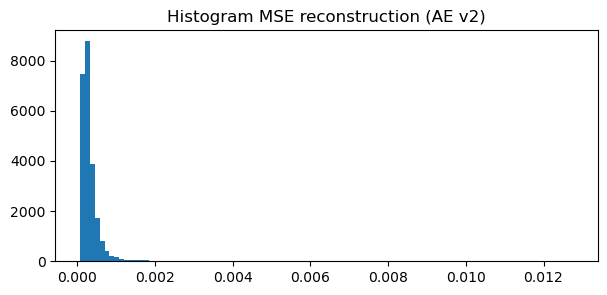

MSE mean/median/std: 0.00033124877 0.00024478103 0.00039524917
Silhouette (subset): 0.14771275222301483


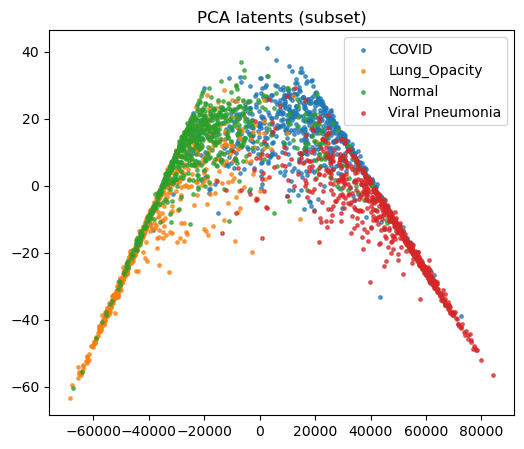

Saved latents_all_scaled.npy


/home/hack/miniconda3/envs/rpp2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/hack/miniconda3/envs/rpp2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy (logistic on scaled latents): 0.621875
                 precision    recall  f1-score   support

          COVID       0.68      0.47      0.56      1200
   Lung_Opacity       0.60      0.82      0.69      1200
         Normal       0.48      0.34      0.40      1200
Viral Pneumonia       0.69      0.86      0.77      1200

       accuracy                           0.62      4800
      macro avg       0.61      0.62      0.60      4800
   weighted avg       0.61      0.62      0.60      4800



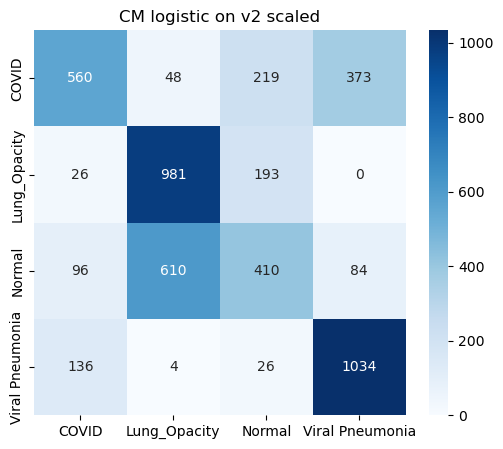

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# 1) Histogram MSE using saved history or recompute per-sample MSE
feat_index = pd.read_csv(FEAT_INDEX_PATH)
mse_list = []
with torch.no_grad():
    for r in tqdm(feat_index.itertuples(), total=len(feat_index), desc="Compute per-sample MSE v2"):
        feat = np.load(r.feat_path).astype(np.float32)
        x = torch.from_numpy(feat).unsqueeze(0).to(DEVICE)
        recon, z = model(x)
        recon_np = recon.cpu().numpy().squeeze(0)
        mse_list.append(((feat - recon_np)**2).mean())
mse_arr = np.array(mse_list)
plt.figure(figsize=(7,3)); plt.hist(mse_arr, bins=100); plt.title("Histogram MSE reconstruction (AE v2)"); plt.show()
print("MSE mean/median/std:", mse_arr.mean(), np.median(mse_arr), mse_arr.std())

# 2) load latents and silhouette (full subset)
Z = np.load("latents_all.npy")
labs = np.load("latents_labels.npy", allow_pickle=True)
n_sub = min(3000, Z.shape[0])
idxs = np.random.choice(Z.shape[0], size=n_sub, replace=False)
Zs = Z[idxs]; labs_s = labs[idxs]
from sklearn.preprocessing import LabelEncoder
le_temp = LabelEncoder(); y_num = le_temp.fit_transform(labs_s)
sil = silhouette_score(Zs, y_num)
print("Silhouette (subset):", sil)

# 3) PCA scatter
Zp = PCA(n_components=2).fit_transform(Zs)
plt.figure(figsize=(6,5))
for c in np.unique(labs_s):
    mask = labs_s==c
    plt.scatter(Zp[mask,0], Zp[mask,1], s=6, alpha=0.7, label=c)
plt.legend(); plt.title("PCA latents (subset)"); plt.show()

# 4) Logistic regression on scaled latents (train/test split stratified)
scaler = StandardScaler().fit(Z)
Z_scaled = scaler.transform(Z)
np.save("latents_all_scaled.npy", Z_scaled)
print("Saved latents_all_scaled.npy")

le_all = LabelEncoder()
y_all = le_all.fit_transform(labs)
Xtr, Xte, ytr, yte = train_test_split(Z_scaled, y_all, test_size=0.2, stratify=y_all, random_state=42)
clf = LogisticRegression(max_iter=2000, multi_class='ovr', solver='liblinear')
clf.fit(Xtr, ytr)
y_pred = clf.predict(Xte)
print("Accuracy (logistic on scaled latents):", accuracy_score(yte, y_pred))
print(classification_report(yte, y_pred, target_names=le_all.classes_))
cm = confusion_matrix(yte, y_pred)
plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_all.classes_, yticklabels=le_all.classes_, cmap='Blues'); plt.title("CM logistic on v2 scaled"); plt.show()


#### Funciones extras

In [23]:
def show_reconstructions_n(n=6):
    feat_index = pd.read_csv(FEAT_INDEX_PATH)
    sel = np.random.choice(len(feat_index), size=min(n, len(feat_index)), replace=False)
    fig, axs = plt.subplots(n, 3, figsize=(14, 3*n))
    for i, idx in enumerate(sel):
        row = feat_index.iloc[idx]
        feat = np.load(row.feat_path).astype(np.float32)
        x = torch.from_numpy(feat).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            recon, z = model(x)
        recon_np = recon.cpu().numpy().squeeze(0)
        mse = float(((feat - recon_np)**2).mean())
        axs[i,0].plot(feat); axs[i,0].set_title("Input features")
        axs[i,1].plot(recon_np); axs[i,1].set_title(f"Reconstruction (MSE={mse:.2e})")
        try:
            img = Image.open(row.filepath).convert('L').resize((299,299))
            axs[i,2].imshow(img, cmap='gray'); axs[i,2].set_title("Original image")
        except Exception:
            axs[i,2].text(0.5,0.5,"Image not found", ha='center')
        for a in axs[i]: a.axis('off')
    plt.tight_layout(); plt.show()

#### Pruebas

##### Feature Reconstructions y MSE

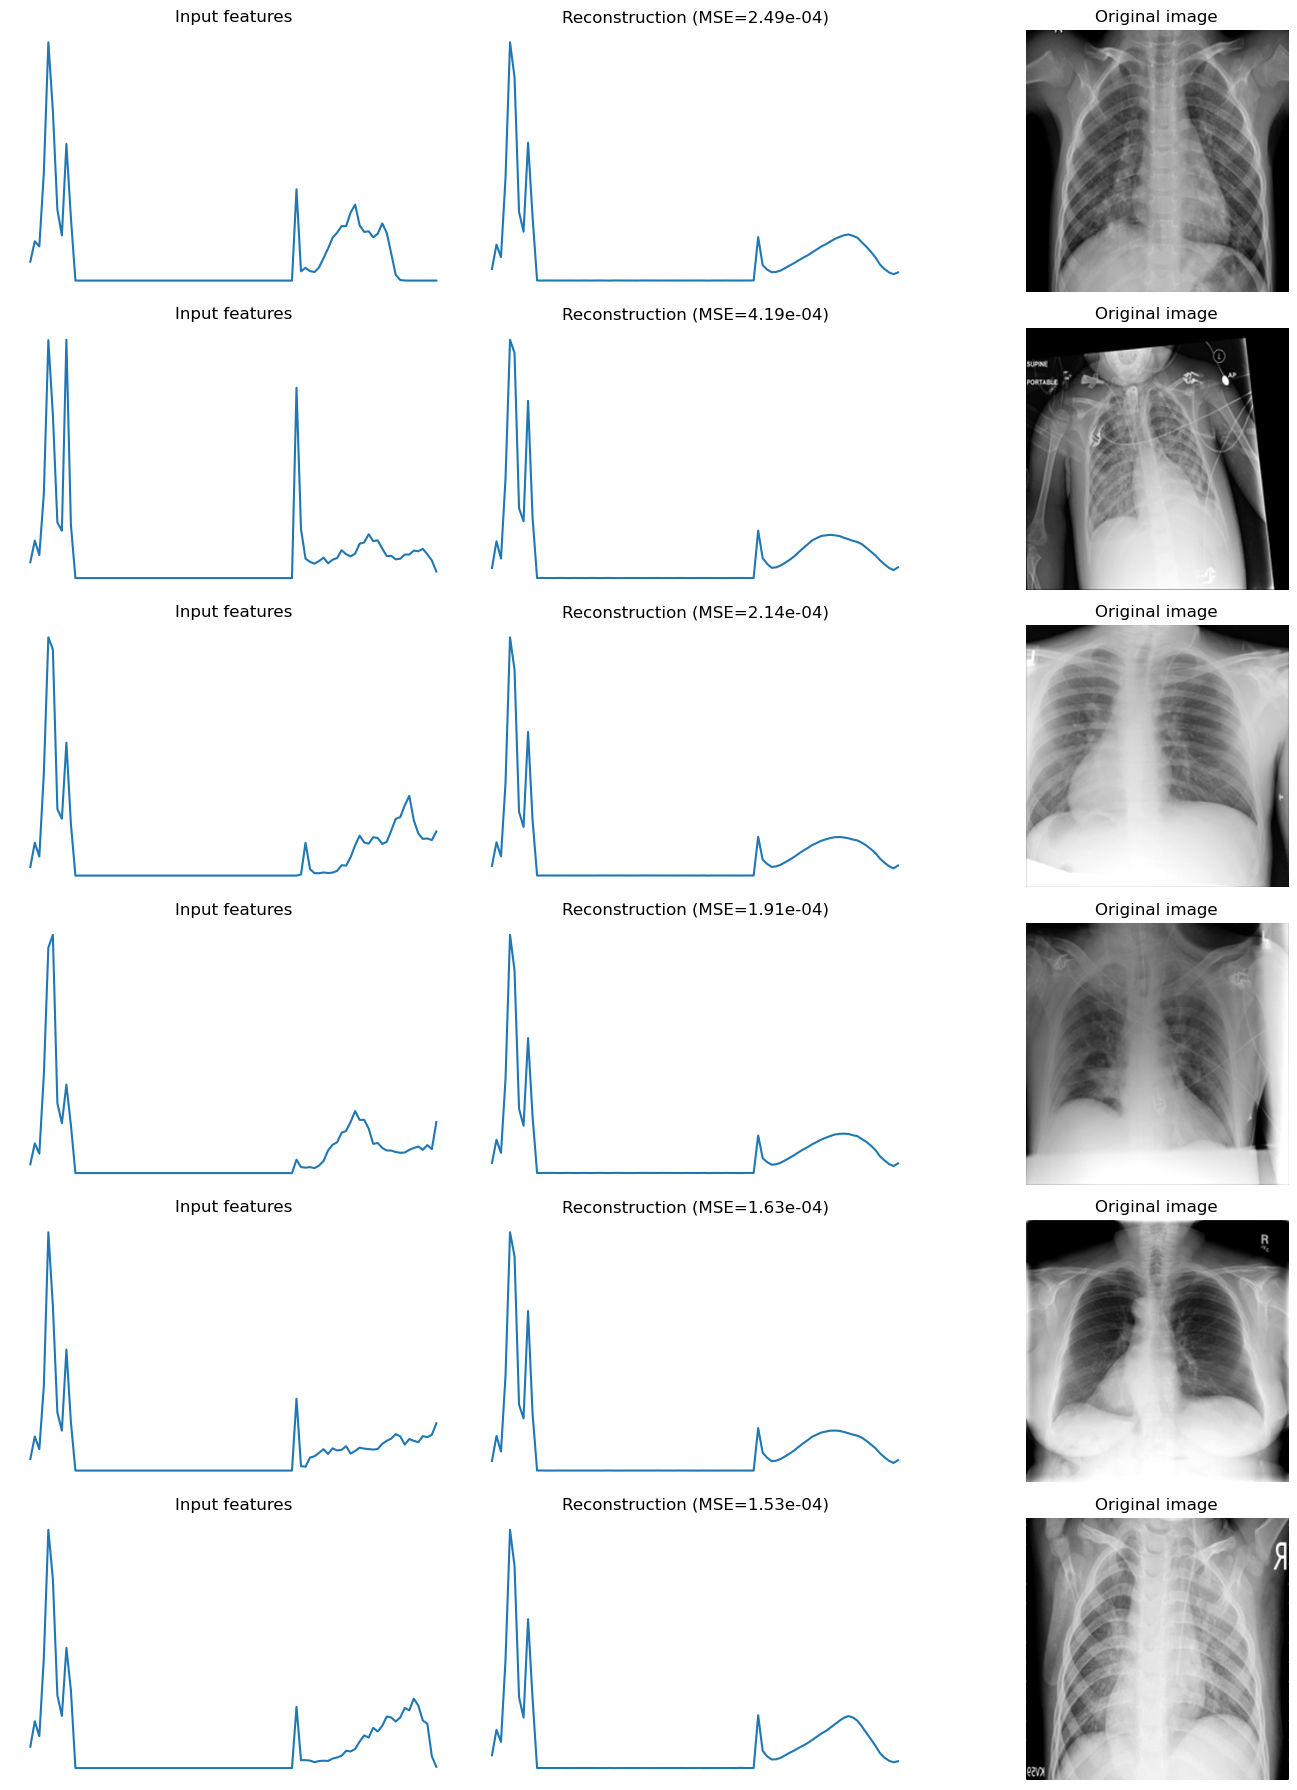

In [24]:
show_reconstructions_n(n=6)

# MLP

In [ ]:
import numpy as np, pandas as pd, time, os
from pathlib import Path
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)


DEVICE: cpu


In [ ]:
class LatentNPYDataset(Dataset):
    def __init__(self, X_path, y_path):
        self.X = np.load(X_path)
        self.y = np.load(y_path)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx].astype('float32')), int(self.y[idx])

# paths (asegúrate que existen)
Xtr_path = "train_latents.npy"; ytr_path = "train_labels.npy"
Xval_path = "val_latents.npy"; yval_path = "val_labels.npy"
Xte_path = "test_latents.npy"; yte_path = "test_labels.npy"

train_ds = LatentNPYDataset(Xtr_path, ytr_path)
val_ds = LatentNPYDataset(Xval_path, yval_path)
test_ds = LatentNPYDataset(Xte_path, yte_path)

# Weighted sampler for class imbalance in training set
y_train = np.load(ytr_path)
from collections import Counter
counter = Counter(y_train)
class_weights = {cls: 1.0/count for cls,count in counter.items()}
sample_weights = [class_weights[int(l)] for l in y_train]
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=128, sampler=train_sampler, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)
print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))


Dataset sizes: 16799 3601 3600


In [ ]:
class MLP_Small(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self,x): return self.net(x)

class MLP_Medium(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self,x): return self.net(x)

class MLP_Large(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self,x): return self.net(x)

# training / evaluation helpers
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss=0; n=0
    for xb, yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0); n += xb.size(0)
    return total_loss / n

def evaluate(model, loader, device):
    model.eval()
    preds=[]; trues=[]
    with torch.no_grad():
        for xb, yb in loader:
            xb=xb.to(device)
            out = model(xb)
            p = out.argmax(dim=1).cpu().numpy()
            preds.extend(p.tolist())
            trues.extend(yb.numpy().tolist())
    acc = accuracy_score(trues, preds)
    report = classification_report(trues, preds, output_dict=True)
    cm = confusion_matrix(trues, preds)
    return acc, report, cm


In [ ]:
input_dim = np.load(Xtr_path).shape[1]
n_classes = len(np.unique(np.load(ytr_path)))
models = {
    'small': MLP_Small(input_dim, n_classes),
    'medium': MLP_Medium(input_dim, n_classes),
    'large': MLP_Large(input_dim, n_classes)
}
results = []
epochs = 30
for name, m in models.items():
    print("Training", name)
    m = m.to(DEVICE)
    opt = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-5)
    # weighted loss by inverse class frequency (optional)
    counts = np.bincount(np.load(ytr_path))
    weights = torch.tensor((1.0 / (counts + 1e-9)), dtype=torch.float).to(DEVICE)
    crit = nn.CrossEntropyLoss(weight=weights)
    best_val_acc = 0; best_state=None
    for ep in range(1, epochs+1):
        t0 = time.time()
        tr_loss = train_one_epoch(m, train_loader, opt, crit, DEVICE)
        val_acc, val_rep, _ = evaluate(m, val_loader, DEVICE)
        dt = time.time()-t0
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = m.state_dict()
        if ep % 5 == 0 or ep==1:
            print(f"{name} E{ep} tr_loss={tr_loss:.5f} val_acc={val_acc:.4f} time={dt:.1f}s")
    # load best and evaluate on test
    m.load_state_dict(best_state)
    test_acc, test_rep, test_cm = evaluate(m, test_loader, DEVICE)
    # save model
    torch.save(m.state_dict(), f"mlp_{name}.pth")
    print(f"Final test_acc {name}: {test_acc:.4f}")
    results.append({'model': name, 'val_acc': best_val_acc, 'test_acc': test_acc, 'report': test_rep, 'cm': test_cm})

# Save summary CSV
rows=[]
for r in results:
    rows.append({'model': r['model'], 'val_acc': r['val_acc'], 'test_acc': r['test_acc']})
pd.DataFrame(rows).to_csv("mlp_comparison_summary.csv", index=False)
print("Saved mlp_comparison_summary.csv")


Training small
small E1 tr_loss=1.27681 val_acc=0.5071 time=5.6s
small E5 tr_loss=1.02826 val_acc=0.6029 time=4.8s
small E10 tr_loss=0.92941 val_acc=0.6395 time=4.0s
small E15 tr_loss=0.88938 val_acc=0.6559 time=4.8s
small E20 tr_loss=0.85982 val_acc=0.6659 time=4.9s
small E25 tr_loss=0.84520 val_acc=0.6854 time=5.3s
small E30 tr_loss=0.82792 val_acc=0.6851 time=5.2s
Final test_acc small: 0.6850
Training medium
medium E1 tr_loss=1.04194 val_acc=0.6104 time=13.2s
medium E5 tr_loss=0.85855 val_acc=0.6918 time=15.9s
medium E10 tr_loss=0.82577 val_acc=0.6940 time=15.1s
medium E15 tr_loss=0.80583 val_acc=0.7059 time=15.3s
medium E20 tr_loss=0.79267 val_acc=0.7106 time=15.1s
medium E25 tr_loss=0.76840 val_acc=0.7206 time=15.4s
medium E30 tr_loss=0.77252 val_acc=0.7176 time=16.2s
Final test_acc medium: 0.7197
Training large
large E1 tr_loss=1.00785 val_acc=0.6243 time=21.0s
large E5 tr_loss=0.83770 val_acc=0.6956 time=22.5s
large E10 tr_loss=0.78296 val_acc=0.7098 time=24.6s
large E15 tr_loss

=== MODEL: small  test_acc: 0.685
              precision    recall  f1-score   support
0              0.710345  0.686667  0.698305   900.000
1              0.650862  0.671111  0.660832   900.000
2              0.628736  0.607778  0.618079   900.000
3              0.747854  0.774444  0.760917   900.000
accuracy       0.685000  0.685000  0.685000     0.685
macro avg      0.684449  0.685000  0.684533  3600.000
weighted avg   0.684449  0.685000  0.684533  3600.000


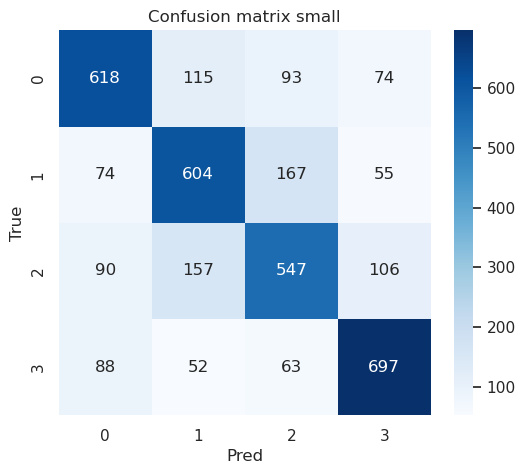

=== MODEL: medium  test_acc: 0.7197222222222223
              precision    recall  f1-score      support
0              0.772059  0.700000  0.734266   900.000000
1              0.682609  0.697778  0.690110   900.000000
2              0.680328  0.645556  0.662486   900.000000
3              0.744554  0.835556  0.787435   900.000000
accuracy       0.719722  0.719722  0.719722     0.719722
macro avg      0.719887  0.719722  0.718574  3600.000000
weighted avg   0.719887  0.719722  0.718574  3600.000000


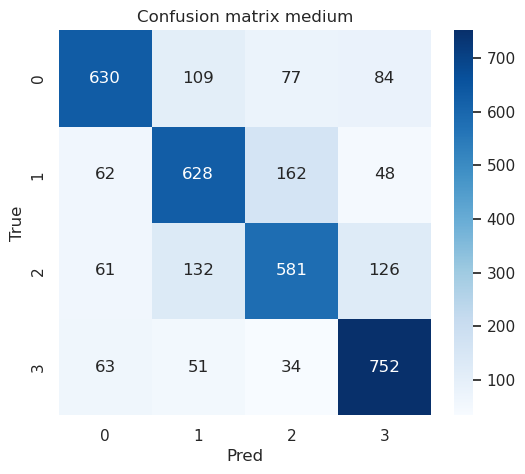

=== MODEL: large  test_acc: 0.7472222222222222
              precision    recall  f1-score      support
0              0.850529  0.714444  0.776570   900.000000
1              0.692955  0.732222  0.712048   900.000000
2              0.714286  0.644444  0.677570   900.000000
3              0.747456  0.897778  0.815750   900.000000
accuracy       0.747222  0.747222  0.747222     0.747222
macro avg      0.751306  0.747222  0.745484  3600.000000
weighted avg   0.751306  0.747222  0.745484  3600.000000


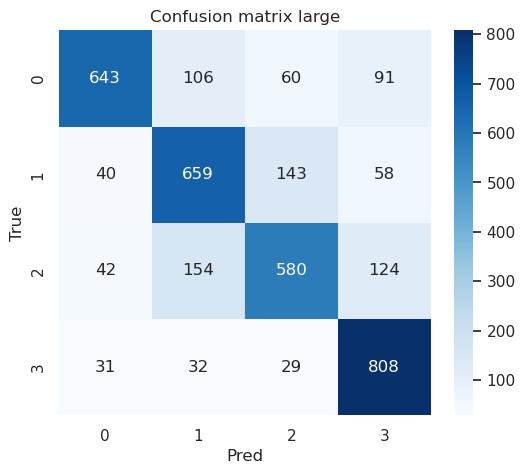

In [ ]:
for r in results:
    print("=== MODEL:", r['model'], " test_acc:", r['test_acc'])
    print(pd.DataFrame(r['report']).transpose())
    plt.figure(figsize=(6,5))
    sns.heatmap(r['cm'], annot=True, fmt='d', xticklabels=np.unique(np.load("train_labels.npy")), yticklabels=np.unique(np.load("train_labels.npy")), cmap='Blues')
    plt.title("Confusion matrix "+r['model'])
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.show()
